# Аналитика бизнес-показателей в Яндекс.Афише

    Аннализ данных от Яндекс.Афиши с июня 2017 по конец мая 2018 года.
    Цель: помочь маркетологам оптимизировать маркетинговые затраты.
    Найти оптимальные источники/платформы.

## Содержание:
* [Шаг 1. Общая информация](#1-bullet)
* [Шаг 2. Предобработка данных](#2-bullet)
* 2.1. [Переименование столбцов](#2-1-bullet)
* 2.2. [Изменение типов данных](#2-2-bullet)
* [Шаг 3. Построение отчетов и расчет метрик](#3-bullet)
* 3.1. [Продукт](#3-1-bullet)
* [DAU, WAU, MAU](#3-1-1-bullet)
* [Sticky factor](#3-1-2-bullet)
* [ASL или средняя продолжительность сессии](#3-1-3-bullet)
* [Retention Rate по визитам](#3-1-4-bullet)
* 3.2. [Продажи](#3-2-bullet)
* [Через какое время совершается покупка](#3-2-1-bullet)
* [Сколько раз покупают за период](#3-2-2-bullet)
* [Средний чек в когортах по месяцам](#3-2-3-bullet)
* [Retention rate по покупкам](#3-2-4-bullet)
* [Экономика одного покупателя LTV, CAC, ROMI](#3-2-5-bullet)
* 3.3. [Маркетинг](#3-3-bullet)
* [Затраты на рекламные источники](#3-3-1-bullet)
* [Стоимость привлечения 1 покупателя](#3-3-2-bullet)
* [ROMI, окупаемость расходов на рекламу](#3-3-3-bullet)
* [Анализ посещаемости ресурса по типу устройства](#3-3-4-bullet)
* [Шаг 4. Общий вывод](#4-bullet)

## Шаг 1. Общая информация <a class="anchor" id="1-bullet"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter  


In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head(7)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451


***Таблица visits (лог сервера с информацией о посещениях сайта):***

* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


   
    В таблице visits 359 400 строк, пропущенные значения отсутствуют.
    В колонках ['End Ts'] и ['Start Ts'] необходимо изменить тип данных на datetime.    
    Для удобства в работе необходимо переименовать столбцы и привезти наименование к
    нижнему регистру.

In [4]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head(7)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638


***Таблица orders (информация о заказах):***

* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


    В таблице orders 50415 строк, пропушенные значения отсутствуют.
    В колонке ['Buy Ts'] необходимо изменить тип данных на datetime.
    Для удобства в работе необходимо переименовать столбцы и привезти наименование
    к нижнему регистру.

In [6]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head(7)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59


***Таблица costs (информация о затратах на маркетинг):***

* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

In [7]:
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


    В таблице 2542 строки, пропущенные значения отсутствуют.
    В колонке ['dt'] необходимо изменить тип данных на datetime и переимовать столбец.


### 2. Предобработка данных<a class="anchor" id="2-bullet"></a>

### 2.1 Переименование столбцов<a class="anchor" id="2-1-bullet"></a>

In [9]:
visits.columns = ['device','session_end_t', 'source_id', 'session_start_t', 'uid']
visits.head()

,device,session_end_t,source_id,session_start_t,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [10]:
orders.rename(columns={'Buy Ts': 'order_date_t', 'Revenue': 'revenue', 'Uid': 'uid'}, inplace=True)
orders.head()

,order_date_t,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [11]:
costs.rename(columns={'dt': 'date'}, inplace=True)
costs.head()

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


### 2.2 Изменение типов данных<a class="anchor" id="2-2-bullet"></a>

In [12]:
visits['session_end_t'] = pd.to_datetime(visits['session_end_t'])

visits['session_start_t'] = pd.to_datetime(visits['session_start_t'])

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device             359400 non-null object
session_end_t      359400 non-null datetime64[ns]
source_id          359400 non-null int64
session_start_t    359400 non-null datetime64[ns]
uid                359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [13]:
visits.head()

,device,session_end_t,source_id,session_start_t,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [14]:
orders['order_date_t'] = pd.to_datetime(orders['order_date_t'])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_date_t    50415 non-null datetime64[ns]
revenue         50415 non-null float64
uid             50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [15]:
orders.head()

,order_date_t,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [16]:
costs['date'] = pd.to_datetime(costs['date'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


## Шаг 3. Построение отчётов и расчет метрик<a class="anchor" id="3-bullet"></a>

### 3.1. Продукт<a class="anchor" id="3-1-bullet"></a>

### Сколько людей пользуются Яндекс.Афише в день, неделю, месяц?

In [17]:
visits['day'] = visits['session_start_t'].dt.date
visits['week'] = visits['session_start_t'].dt.week 
visits['month'] = visits['session_start_t'].dt.month
visits['year']  = visits['session_start_t'].dt.year


In [18]:
visits.head(5)

,device,session_end_t,source_id,session_start_t,uid,day,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017


In [19]:
visits['day'] = pd.to_datetime(visits['day'])

In [20]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 9 columns):
device             359400 non-null object
session_end_t      359400 non-null datetime64[ns]
source_id          359400 non-null int64
session_start_t    359400 non-null datetime64[ns]
uid                359400 non-null uint64
day                359400 non-null datetime64[ns]
week               359400 non-null int64
month              359400 non-null int64
year               359400 non-null int64
dtypes: datetime64[ns](3), int64(4), object(1), uint64(1)
memory usage: 24.7+ MB


### Рассчитаем DAU, WAU, MAU<a class="anchor" id="3-1-1-bullet"></a>

In [21]:
dau_total = visits.groupby('day').agg({'uid': 'nunique'}).mean()
dau_total = dau_total.round()
print('DAU, количество уникальных пользователей в день:', dau_total)

DAU, количество уникальных пользователей в день: uid    908.0
dtype: float64


In [22]:
wau_total = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
wau_total = wau_total.round()
print('WAU, количество уникальных пользователей в неделю:', wau_total)

WAU, количество уникальных пользователей в неделю: uid    5716.0
dtype: float64


In [23]:
mau_total = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()
mau_total = mau_total.round()
print('MAU, количество уникальных пользователей в месяц:', mau_total)

MAU, количество уникальных пользователей в месяц: uid    23228.0
dtype: float64


   
**Посмотрим динамику изменения количества уникальных пользователей в месяц MAU**

In [24]:
dynamics_mau_total = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).round()
dynamics_mau_total.head(15)

uid
year month       
2017 6      13259
     7      14183
     8      11631
     9      18975
     10     29692
     11     32797
     12     31557
2018 1      28716
     2      28749
     3      27473
     4      21008
     5      20701

Text(0.5, 1.0, 'Количества уникальных пользователей в месяц')

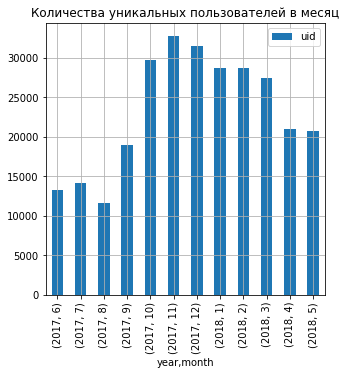

In [25]:
dynamics_mau_total = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).plot(kind='bar', grid=True, figsize=(5, 5))
plt.title('Количества уникальных пользователей в месяц')

По Динамике:
* июнь, июль, август 2017 - среднее количество уникальных пользователей в месяц не превышает 14200 человек.
* рост количества начинается с сентября 2017.
* максимально количество уникальных пользователей в день приходится на ноябрь 2017 год (32797 человек).
* спад начинается в апреле, мае 2019

### Sticky factor, частота и регулярность использования приложения<a class="anchor" id="3-1-2-bullet"></a>

In [26]:
sticky_mau = dau_total / mau_total * 100
sticky_wau = dau_total / wau_total * 100
print('Sticky Factor (недельный)', sticky_wau.round(1))
print('Sticky Factor (месячный)', sticky_mau.round(1))

Sticky Factor (недельный) uid    15.9
dtype: float64
Sticky Factor (месячный) uid    3.9
dtype: float64


    Sticky factor - показатель лояльности аудитории к сервису.
    Показывает частоту и регулярность использования сервиса в течении недели или месяца.
    
    Нормальным считается показатель Sticky factor месячный - порядка 18%.
    В данном случае 3,9%. Если каждый пользователь в течение месяца заходил лишь один раз
    показатель равен 3,3%. Чем выше этот показатель, тем регулярнее пользователи заходят в
    приложение.

### Средняя продолжительность сессии или ASL<a class="anchor" id="3-1-3-bullet"></a>

In [27]:
visits['session_duration_sec'] = (visits['session_end_t'] - visits['session_start_t']).dt.seconds
print(visits['session_duration_sec'].mean().round(2))

643.51


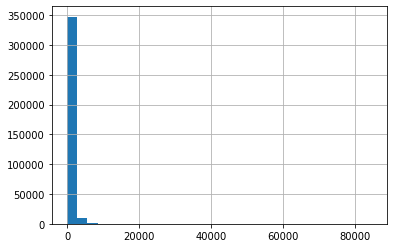

In [28]:
visits['session_duration_sec'].hist(bins=30)

    Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю
    или медиану. Но данное распределение не является нормальным, поэтому рассчитаем моду
    (значение в выборке, которое встречается чаще всего):

In [29]:
print(visits['session_duration_sec'].mode())

0    60
dtype: int64


    Средняя продолжительность сессии длится - 60 секунд
    
    



### Сколько сессий в день?

In [30]:
sessions_per_user = visits.groupby(['year', 'day']).agg({'uid': ['count','nunique']}).mean()
print(sessions_per_user.round())

uid  count      987.0
     nunique    908.0
dtype: float64


    В среднем в день совершается 985 сессий. Из них 906 сессий от уникальных пользователей.


    
**Посмотрим на динамику совершаемых сессий в день**
    

In [31]:
sessions_per_user_1 = visits.groupby(['year', 'month', 'day']).agg({'uid':['count', 'nunique']})

In [32]:
sessions_per_user_1.columns = ['count', 'n_sessions_per_day']

In [33]:
sessions_per_user_1.groupby(['year', 'month']).agg({'n_sessions_per_day':'mean'}).round()

n_sessions_per_day
year month                    
2017 6                   511.0
     7                   532.0
     8                   433.0
     9                   739.0
     10                 1133.0
     11                 1329.0
     12                 1241.0
2018 1                  1097.0
     2                  1217.0
     3                  1053.0
     4                   846.0
     5                   786.0

Text(0.5, 1.0, 'Количество сессий в день')

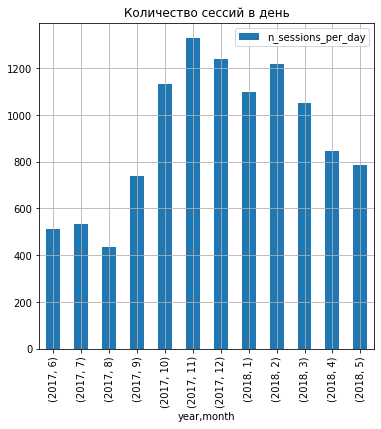

In [34]:
sessions_per_user_1.groupby(['year', 'month']).agg({'n_sessions_per_day':'mean'}).plot(kind='bar', grid=True, figsize=(6, 6))
plt.title('Количество сессий в день')

   
    По динамике сессий в день:
    * июнь, июль, август 2017 - среднее количество сессий в день не превышает 550 шт.
    * рост количества начинается с сентября 2017.
    * максимально количество сессий в день приходится на ноябрь 2017 год (1329 шт в среднем).
    * заметный спад начинается в апреле, мае 2019

### Как часто люди возвращаются?

In [35]:
visits['session_end_wt'] = pd.to_datetime(visits['session_end_t']).dt.normalize()
visits['session_start_wt'] = pd.to_datetime(visits['session_start_t']).dt.normalize()

In [36]:
first_visit_date = visits.groupby(['uid'])['session_start_wt'].min()
first_visit_date.name = 'first_visit_date'
visits = visits.join(first_visit_date,on='uid')
visits.head()

,device,session_end_t,source_id,session_start_t,uid,day,week,month,year,session_duration_sec,session_end_wt,session_start_wt,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20,2017-12-20,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-05-20,2018-05-20,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0,2017-12-27,2017-12-27,2017-12-27


In [37]:
visits['activity_montn'] = visits['session_start_wt'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_visit_date'].astype('datetime64[M]')

In [38]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 15 columns):
device                  359400 non-null object
session_end_t           359400 non-null datetime64[ns]
source_id               359400 non-null int64
session_start_t         359400 non-null datetime64[ns]
uid                     359400 non-null uint64
day                     359400 non-null datetime64[ns]
week                    359400 non-null int64
month                   359400 non-null int64
year                    359400 non-null int64
session_duration_sec    359400 non-null int64
session_end_wt          359400 non-null datetime64[ns]
session_start_wt        359400 non-null datetime64[ns]
first_visit_date        359400 non-null datetime64[ns]
activity_montn          359400 non-null datetime64[ns]
first_activity_month    359400 non-null datetime64[ns]
dtypes: datetime64[ns](8), int64(5), object(1), uint64(1)
memory usage: 41.1+ MB


   
**Посмортим число пользователей в каждой когорте**

In [39]:
cohort_grouped = visits.groupby('first_activity_month').agg({'uid':'nunique','session_start_wt':'count'}).reset_index()
cohort_grouped.columns = ['cohort', 'qty_users', 'qty_sessions']
cohort_grouped.head(15)

,cohort,qty_users,qty_sessions
0,2017-06-01,13259,40863
1,2017-07-01,13140,25370
2,2017-08-01,10181,18671
3,2017-09-01,16704,28795
4,2017-10-01,25977,41682
5,2017-11-01,27248,44383
6,2017-12-01,25268,36258
7,2018-01-01,22624,31189
8,2018-02-01,22197,29099
9,2018-03-01,20589,26269


    С декабря 2017 число пользователей в каждой следующей когорте падает.
    Значит, в Яндекс.Афиша со временем приходит всё меньше и меньше новых пользователей. 

    Пик посещений приходится на когорты октября и ноября. Далее количество посещений по каждой следующей когорте
    меньше предыдущей. Это логично, ведь более старые когорты существуют дольше, и пользователи из них совершали
    посещения в течение большего времени.


**Посмотрим на количество посещений пользователей в каждой когорте по месяцам**

In [40]:
visits.pivot_table(index='first_activity_month', columns='activity_montn', values='uid', aggfunc='nunique')

activity_montn,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_activity_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,NaN,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0
2017-08-01,NaN,NaN,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0
2017-09-01,NaN,NaN,NaN,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0
2017-10-01,NaN,NaN,NaN,NaN,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,25268.0,1410.0,960.0,786.0,512.0,481.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22624.0,1351.0,890.0,565.0,458.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22197.0,1267.0,565.0,446.0


   
    * После первого месяца количество посетителей в когорте сильно снижается. 
    * В когортах октября и ноября самое большое количество посителей за месяц и далее кличество сокращается
    по месяцам меньше, чем в других когортах.
    * В когорте июня 2017 примерно такое же количество посещений, что и в "максимальных" когортах октября и ноября 2017



***RETENTION RATE*** **по количеству визитов пользователей** <a class="anchor" id="3-1-4-bullet"></a>

In [41]:
visits['activity_montn'] = visits['session_start_wt'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_visit_date'].astype('datetime64[M]')

In [42]:
visits['cohort_lifetime'] = visits['activity_montn'] - visits['first_activity_month']

In [43]:
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)

In [44]:
visits_cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [45]:
visits_inital_users_count = visits_cohorts[visits_cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

In [46]:
visits_inital_users_count = visits_inital_users_count.rename(columns={'uid':'cohort_users'})

In [47]:
visits_cohorts = visits_cohorts.merge(visits_inital_users_count,on='first_activity_month')

In [48]:
visits_cohorts['retention'] = visits_cohorts['uid']/visits_cohorts['cohort_users']

In [49]:
visits_retention_pivot = visits_cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

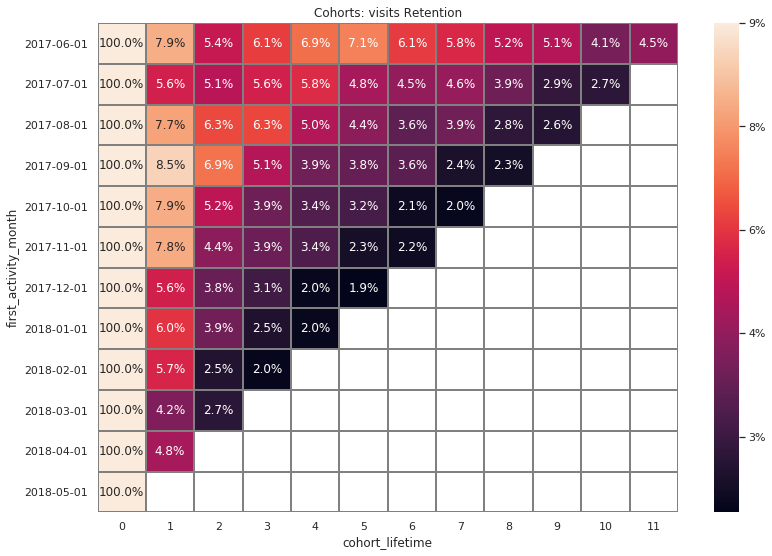

In [50]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: visits Retention')
fmt = lambda x,pos: '{:.0%}'.format(x) 
heatmap = sns.heatmap(visits_retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.09,
            cbar_kws={'format': FuncFormatter(fmt)})

y_labels = heatmap.set_yticklabels(visits_retention_pivot.index.date)  

    В первый месяц мы видим низкий коэфициет удержания:
    * до декабря 2017 - от 7,7% до 8,5% (исключение составляет июль 2017 - 5,6%)
    * с декабря 2017 - от 6 % до 4,2%

    Это важный сигнал того, что нужно сосредоточиться на удержании покупателей в первый месяц, ведь большая часть
    активных покупателей отказывается от сервиса именно в этот период. 
    
    Самый высокий Retention Rate в первый месяц в когорте сентября 2017 года (8,5%). 
  
    В 7 когортах каждый месяц последовательно происходит снижение коэфициента удержания (это когорты с сентября 2017
    по март 2018). Апрель не берем в рассчет, так как когорте 1 месяц.
    
    В 3 когортах после падения был рост. Необходимо дополнительно изучить, что привело к увеличению визитов в эти месяцы.

    * июнь 2017 - рост на 3,4 и 5 месяце жизни
    * июль 2017 - рост на 3,4 и 7 месяце жизни
    * август 2017 - рост на 7 месяце жизни
    
    У первый когорты самый высокий коэфициент удержания даже спустя год жизни - 4,5%

### 3.2. Продажи <a class="anchor" id="3-2-bullet"></a>

### Через какое время совершается покупка?<a class="anchor" id="3-2-1-bullet"></a>

In [51]:
pd.to_datetime(orders['order_date_t'], format='%Y.%m.%d')
orders['date'] = pd.to_datetime(orders['order_date_t']).dt.normalize()

In [52]:
first_order_date_by_customers = orders.groupby('uid')['date'].min()
first_order_date_by_customers.name = 'first_order_date'
orders = orders.join(first_order_date_by_customers,on='uid')

In [53]:
orders.head()

,order_date_t,revenue,uid,date,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [54]:
sales = orders.merge(visits, on='uid', how='left')
sales.head()

,order_date_t,revenue,uid,date,first_order_date,device,session_end_t,source_id,session_start_t,day,week,month,year,session_duration_sec,session_end_wt,session_start_wt,first_visit_date,activity_montn,first_activity_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017-06-01,22,6,2017,120,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017-06-01,22,6,2017,660,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017-06-01,22,6,2017,540,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017-06-01,22,6,2017,1140,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017-06-01,22,6,2017,1680,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01,0


In [55]:
new_sales = sales[(sales['session_end_t'] >= sales['order_date_t']) &
(sales['session_start_t'] <= sales ['order_date_t'])]

In [56]:
new_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35927 entries, 0 to 761806
Data columns (total 20 columns):
order_date_t            35927 non-null datetime64[ns]
revenue                 35927 non-null float64
uid                     35927 non-null uint64
date                    35927 non-null datetime64[ns]
first_order_date        35927 non-null datetime64[ns]
device                  35927 non-null object
session_end_t           35927 non-null datetime64[ns]
source_id               35927 non-null int64
session_start_t         35927 non-null datetime64[ns]
day                     35927 non-null datetime64[ns]
week                    35927 non-null int64
month                   35927 non-null int64
year                    35927 non-null int64
session_duration_sec    35927 non-null int64
session_end_wt          35927 non-null datetime64[ns]
session_start_wt        35927 non-null datetime64[ns]
first_visit_date        35927 non-null datetime64[ns]
activity_montn          35927 non-null d

In [57]:
sales['order_duration_day'] = (sales['order_date_t'] - sales['session_start_t'])

In [58]:
print(sales['order_duration_day'].mode())

0   00:01:00
dtype: timedelta64[ns]


    В среднем пользователи начинают покупать через минуту после начала сессии. Т.е. пользователи знают точно,
    что они хотят приобрести. Как мы выяснили ранее продолжительность сессии в среднем 60 сек.
    

### Сколько раз покупают за период?<a class="anchor" id="3-2-2-bullet"></a>

In [59]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['date'].astype('datetime64[M]')

In [60]:
sales_cohort_grouped = sales.groupby('first_activity_month').agg({'uid':'nunique','revenue':'sum'}).round().reset_index()
sales_cohort_grouped.columns = ['cohort', 'qty_buyers', 'total_revenue']
sales_cohort_grouped

,cohort,qty_buyers,total_revenue
0,2017-06-01,2923,3929833.0
1,2017-07-01,2458,168692.0
2,2017-08-01,1721,544189.0
3,2017-09-01,3058,1229545.0
4,2017-10-01,4678,171036.0
5,2017-11-01,4262,247140.0
6,2017-12-01,4074,217507.0
7,2018-01-01,3119,134109.0
8,2018-02-01,3186,81970.0
9,2018-03-01,2838,145269.0


    С декабря 2017 число покупателей в каждой следующей кагорте падает.
    Значит, в Яндекс.Афиша со временем приходит всё меньше и меньше новых покупателей. 

    Самая большая сумма продаж в когорте 2017-06-01. Это логично, ведь более старая когорта существует дольше,
    и пользователи из них совершали покупки в течение большего времени.
    
    Так же сильно выделяется когорта 2017-09-01 по сумме продаж, она находится на втором месте.
    Обратим внимание и на когорту 2018-03-01, она обогнала по сумме продаж более старые когорты 2018-02-01 и 2018-01-01


**Посмотрим на продажи в каждой когорте по месяцам**

In [61]:
sales.pivot_table(index='first_activity_month', columns='activity_montn', values='revenue', aggfunc='sum')

activity_montn,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_activity_month,,,,,,,,,,,,
2017-06-01,253324.55,190867.58,184169.16,340679.26,410873.97,434235.59,506566.74,370934.66,340889.52,354163.37,259974.11,283154.87
2017-07-01,NaN,33063.40,11643.67,17275.44,18595.50,18754.31,14325.42,10864.65,7524.36,8122.87,19561.99,8960.75
2017-08-01,NaN,NaN,32645.36,55625.03,40025.20,67131.85,51500.21,33253.72,29229.54,63822.36,80888.14,90068.00
2017-09-01,NaN,NaN,NaN,276332.49,65806.59,130026.74,391614.48,63855.00,170666.63,69010.89,52765.57,9466.58
2017-10-01,NaN,NaN,NaN,NaN,61675.65,31435.79,13267.23,13754.39,13146.93,9304.25,7605.05,20846.85
2017-11-01,NaN,NaN,NaN,NaN,NaN,52090.09,53138.31,38698.74,52499.23,31983.23,9721.91,9008.82
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,61403.61,46009.04,25787.09,65573.87,9485.87,9247.20
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31549.91,49106.70,25602.59,14017.83,13832.10
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38028.37,23648.52,8756.85,11536.37


    
    * После первого месяца количество покупок в когорте снижается. Исключения составляют три когорты, в которых на
    следующий месяц после первого месяца произошел рост: 2017-08-01, 2018-01-01, 2018-03-01.
    
    * Первая когорта приносит больше всего денег даже после года существования когорты.
    
    * Необходимо обратить внимание на когорту 2017-09-01. В первый месяц сущестования в данной когорте максимальная
    сумма продаж. Даже в первой когорте сумма продаж меньше за первый месяц. Был сильный рост в 3,4,5 месяцы.       


    
**Посмотрим количество покупок на пользователя в динамике по месяцам**

In [62]:
orders_per_user = sales.groupby(['year', 'month']).agg({'uid':'nunique', 'order_date_t':'count'})
orders_per_user.columns = ['uid', 'n_orders_per_month']
orders_per_user.round()

uid  n_orders_per_month
year month                          
2017 6      2923               25988
     7      2893               28986
     8      2282               32564
     9      3960               60757
     10     6251               71483
     11     6471               72420
     12     6629              102912
2018 1      5504               77651
     2      5687               82787
     3      5458               75988
     4      3857               60157
     5      4328               70114

In [63]:
orders_per_user['orders_per_user_mean'] = (orders_per_user['n_orders_per_month']/orders_per_user['uid']).round()
orders_per_user

uid  n_orders_per_month  orders_per_user_mean
year month                                                
2017 6      2923               25988                   9.0
     7      2893               28986                  10.0
     8      2282               32564                  14.0
     9      3960               60757                  15.0
     10     6251               71483                  11.0
     11     6471               72420                  11.0
     12     6629              102912                  16.0
2018 1      5504               77651                  14.0
     2      5687               82787                  15.0
     3      5458               75988                  14.0
     4      3857               60157                  16.0
     5      4328               70114                  16.0


    Покупатели в среднем делают от 9 до 16 заказов


### Какой средний чек?

In [64]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})


    Найдем средний чек покупателя

In [65]:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']

In [66]:
orders_grouped_by_cohorts['revenue_per_user'].mean().round(2)

14.73


    Средний чек по всему датасету равен  14,73 у.е.

### Сколько денег приносят пользователи? (средний чек в каждой когорте по месяцам) <a class="anchor" id="3-2-3-bullet"></a>

**Найдём lifetime когорты**

In [67]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']

In [68]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')


In [69]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

In [70]:
orders_grouped_by_cohorts['first_order_month'].dt.strftime('%d.%m.%Y')
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

    Построим сводную таблицу изменения среднего чека, где в столбцах будет lifetime, а строках — когорты:

In [71]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean').round(1)
revenue_per_user_pivot.head(14)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.7,16.1,17.7,35.8,23.5,22.2,31.0,25.0,19.3,27.2,25.7,9.8
2017-07,6.0,12.4,21.0,10.8,6.9,7.9,6.4,7.0,7.4,12.9,11.5,NaN
2017-08,5.3,11.1,11.9,12.2,16.9,12.1,9.6,12.6,21.1,8.3,NaN,NaN
2017-09,5.6,22.2,13.4,138.7,19.9,26.1,27.4,17.0,11.0,NaN,NaN,NaN
2017-10,5.0,11.3,6.8,7.4,7.1,7.3,6.6,7.5,NaN,NaN,NaN,NaN
2017-11,5.2,7.3,6.8,12.5,7.5,4.6,7.6,NaN,NaN,NaN,NaN,NaN
2017-12,4.7,7.8,39.4,48.1,27.4,23.5,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.1,8.7,12.4,11.2,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.2,8.6,4.9,6.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


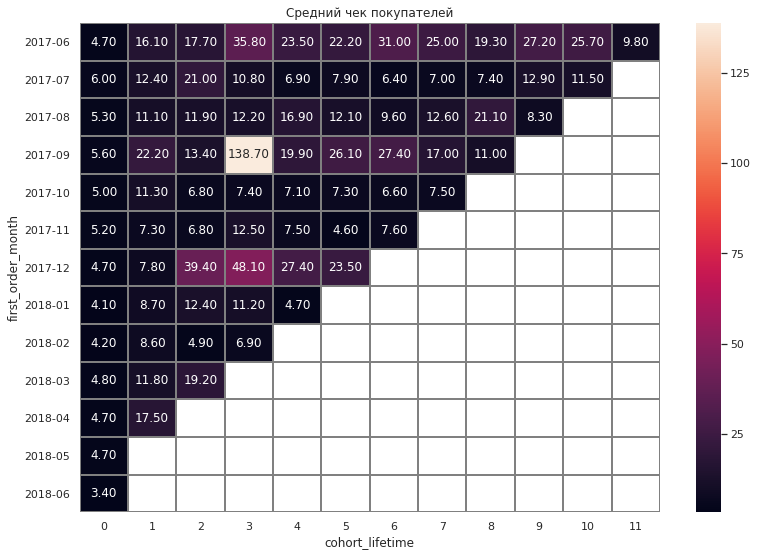

In [72]:
revenue_per_user_pivot = revenue_per_user_pivot

plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

  
    * Видно, что во всех когортах средний чек пользователей возрастает на следующий месяц после месяца первой покупки.
    Кроме когорты мая 2018 года, на следующий месяц после месяца первой покупки - покупки не состоялось.
    
    * В когортах "2018-03" средний чек растёт с течением времени. В остальных когортах средний чек варьируется, то
    идет рост, потом спад и далее опять рост.
    
    * В когорте "2017-09" есть анамально высокое значение среднего чека - 138.7


### Расчёт Retention Rate (Клиенты, совершившие покупки) <a class="anchor" id="3-2-4-bullet"></a>
#### сколько клиентов совершили повторные покупки за определенный период времени?

In [73]:
orders['cohort_lifetime'] = orders['order_month'] - orders['first_order_month']

In [74]:
orders['cohort_lifetime'] = orders['cohort_lifetime'] / np.timedelta64(1,'M')

In [75]:
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int')

In [76]:
orders['first_order_month'].dt.strftime('%d.%m.%Y')
orders['first_order_month'] = orders['first_order_month'].dt.strftime('%Y-%m')

In [77]:
rate_cohorts = orders.groupby(['first_order_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [78]:
inital_users_count = rate_cohorts[rate_cohorts['cohort_lifetime'] == 0][['first_order_month','uid']]


In [79]:
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})
inital_users_count.head()

,first_order_month,cohort_users
0,2017-06,2023
12,2017-07,1923
23,2017-08,1370
33,2017-09,2581
42,2017-10,4340


In [80]:
rate_cohorts = rate_cohorts.merge(inital_users_count,on='first_order_month')

In [81]:
rate_cohorts.head()

,first_order_month,cohort_lifetime,uid,cohort_users
0,2017-06,0,2023,2023
1,2017-06,1,61,2023
2,2017-06,2,50,2023
3,2017-06,3,54,2023
4,2017-06,4,88,2023


In [82]:
rate_cohorts['retention'] = rate_cohorts['uid']/rate_cohorts['cohort_users']
print(rate_cohorts['retention'].mean())

0.1854200310092229


In [83]:
retention_pivot = rate_cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot.head(15)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,1.0,0.030153,0.024716,0.026693,0.043500,0.033119,0.030648,0.023233,0.028670,0.022244,0.022244,0.026199
2017-07,1.0,0.027041,0.029641,0.033281,0.025481,0.019761,0.018721,0.020281,0.021841,0.011440,0.013521,NaN
2017-08,1.0,0.042336,0.038686,0.032117,0.029197,0.023358,0.021898,0.032117,0.013869,0.022628,NaN,NaN
2017-09,1.0,0.050368,0.038745,0.028671,0.020147,0.024797,0.025571,0.014336,0.016660,NaN,NaN,NaN
2017-10,1.0,0.047465,0.028341,0.021198,0.021429,0.016590,0.012903,0.015438,NaN,NaN,NaN,NaN
2017-11,1.0,0.054398,0.029405,0.025974,0.019848,0.011762,0.015192,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.033311,0.023500,0.022131,0.011408,0.014374,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.033798,0.024607,0.012748,0.013341,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.032320,0.015886,0.010682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


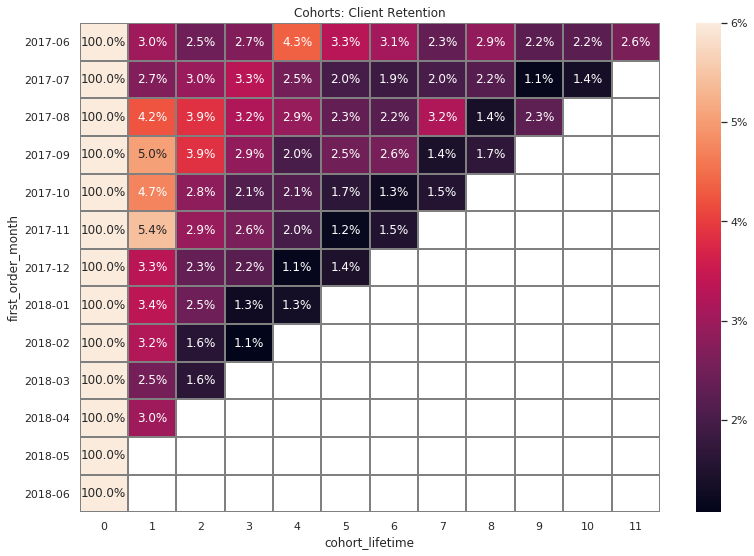

In [84]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Client Retention')
fmt = lambda x,pos: '{:.0%}'.format(x)
heatmap = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.06,
            cbar_kws={'format': FuncFormatter(fmt)})

    
    RETENTION RATE (у клиентов, совершивщих покупки) в первый месяц относительно низкий. Это важный сигнал того,
    что нужно сосредоточиться на удержании покупателей в первый месяц, ведь большая часть активных покупателей
    отказывается от сервиса именно в этот период. 
    
    Видим, что в первый месяц жизни у когорты 2017-11 самый высокий показатель - 5,4%

    До когорты 2017-12 показатель держится в рамках от 4% до 5,4%. Начиная с когорты 2017-12 показатель держится
    в рамках 3,5% - 2,5%. Коэффициент удержания упал. Это говорит, что с каждой новой когортой поведение покупателей 
    меняется. Возможно, были выбраны неэффективные источники рекламы.

    У первый когорты 2017-06 спустя год самый высокий коэфициент на момент снятия отчета - 2,6%



### Считаем экономику одного покупателя (LTV, CAC, ROMI) <a class="anchor" id="3-2-5-bullet"></a>

**Предобработка данных**

In [85]:
orders['date'] = orders['date'].dt.date
orders['date'] = pd.to_datetime(orders['date'])

In [86]:
marketing = orders.merge(costs, on='date', how='inner')
marketing.head()

,order_date_t,revenue,uid,date,first_order_date,first_order_month,order_month,cohort_lifetime,source_id,costs
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01,2017-06-01,2017-06,2017-06-01,0,1,75.20
1,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01,2017-06-01,2017-06,2017-06-01,0,2,132.56
2,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01,2017-06-01,2017-06,2017-06-01,0,3,349.38
3,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01,2017-06-01,2017-06,2017-06-01,0,4,76.74
4,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01,2017-06-01,2017-06,2017-06-01,0,5,73.24


In [87]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352898 entries, 0 to 352897
Data columns (total 10 columns):
order_date_t         352898 non-null datetime64[ns]
revenue              352898 non-null float64
uid                  352898 non-null uint64
date                 352898 non-null datetime64[ns]
first_order_date     352898 non-null datetime64[ns]
first_order_month    352898 non-null object
order_month          352898 non-null datetime64[ns]
cohort_lifetime      352898 non-null int64
source_id            352898 non-null int64
costs                352898 non-null float64
dtypes: datetime64[ns](4), float64(2), int64(2), object(1), uint64(1)
memory usage: 29.6+ MB


In [88]:
marketing['first_order_month'] = pd.to_datetime(marketing['first_order_month'])

**Посчитаем количество новых покупателей (n_buyers) за каждый месяц**

In [89]:
cohort_sizes = marketing.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


    Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.
    Сбросим индекс методом reset_index():

In [90]:
cohorts = marketing.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()


,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,66902.43
1,2017-06-01,2017-07-01,6872.74
2,2017-06-01,2017-08-01,6197.38
3,2017-06-01,2017-09-01,13519.10
4,2017-06-01,2017-10-01,14480.06


    Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [91]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,66902.43
1,2017-06-01,2023,2017-07-01,6872.74
2,2017-06-01,2023,2017-08-01,6197.38
3,2017-06-01,2023,2017-09-01,13519.10
4,2017-06-01,2023,2017-10-01,14480.06


    Найдем валовую прибыль, умножив выручку на маржинальность. LTV удобнее смотреть по «возрастным» когортам,
    где в столбцах — не месяц заказа, а возраст (age) когорты.

In [92]:
margin_rate = 0.5
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,66902.43,33451.215,0
1,2017-06-01,2023,2017-07-01,6872.74,3436.370,1
2,2017-06-01,2023,2017-08-01,6197.38,3098.690,2
3,2017-06-01,2023,2017-09-01,13519.10,6759.550,3
4,2017-06-01,2023,2017-10-01,14480.06,7240.030,4


    Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.

In [93]:
report['ltv'] = report['gp'] / report['n_buyers']    
output = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(1)
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,16.5,1.7,1.5,3.3,3.6,2.6,3.3,2,1.9,2.1,2,0.9
2017-07-01,21.0,1.2,2.2,1.3,0.6,0.5,0.4,0.5,0.6,0.5,0.5,
2017-08-01,18.5,1.7,1.6,1.4,1.7,1,0.7,1.4,1,0.7,,
2017-09-01,19.8,3.9,1.8,13.9,1.4,2.3,2.5,0.9,0.6,,,
2017-10-01,17.5,1.9,0.7,0.6,0.5,0.4,0.3,0.4,,,,
2017-11-01,18.0,1.4,0.7,1.1,0.5,0.2,0.4,,,,,
2017-12-01,16.6,0.9,3.2,3.7,1.1,1.2,,,,,,
2018-01-01,14.5,1,1.1,0.5,0.2,,,,,,,
2018-02-01,14.5,1,0.3,0.3,,,,,,,,


    Посчитаем CAC каждой когорты. Сначала найдём суммарные расходы за каждый месяц,
    а затем поделим их на количество покупателей в каждой когорте:

In [94]:
monthly_costs = marketing.groupby('order_month')['costs'].sum()
monthly_costs.head(15)

order_month
2017-06-01    1626338.91
2017-07-01    1603972.58
2017-08-01     909936.61
2017-09-01    2918340.48
2017-10-01    6854795.46
2017-11-01    8821592.60
2017-12-01    7827395.31
2018-01-01    5204014.33
2018-02-01    6365115.43
2018-03-01    5682217.14
2018-04-01    2596501.06
2018-05-01    3946823.29
Name: costs, dtype: float64

In [95]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='order_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,66902.43,33451.215,0,16.535450,1626338.91,803.924325
1,2017-06-01,2023,2017-07-01,6872.74,3436.370,1,1.698651,1626338.91,803.924325
2,2017-06-01,2023,2017-08-01,6197.38,3098.690,2,1.531730,1626338.91,803.924325
3,2017-06-01,2023,2017-09-01,13519.10,6759.550,3,3.341349,1626338.91,803.924325
4,2017-06-01,2023,2017-10-01,14480.06,7240.030,4,3.578858,1626338.91,803.924325



**Рассчитаем ROMI: поделим LTV на CAC** 

In [96]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.02,0.02,0.02,0.03,0.03,0.04,0.04,0.04,0.05,0.05,0.05,0.05
2017-07-01,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,NaN
2017-08-01,0.03,0.03,0.03,0.03,0.04,0.04,0.04,0.04,0.04,0.04,NaN,NaN
2017-09-01,0.02,0.02,0.02,0.03,0.04,0.04,0.04,0.04,0.04,NaN,NaN,NaN
2017-10-01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN
2017-11-01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.01,0.01,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.01,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.01,0.01,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


    Видим, что не одна когорта на окупилась.
    максимальное ROMI = 0.05 у первой когорты 2017-06-01 на 9 месяце жизни.
    Далее идет значение ROMI = 0.04 (у трех когорт 2017-07-01, 2017-08-01, 2017-09-01)
    У когорты 2018-04-01 на втором месяце жизни ROMI=0.02
    У всех остальных когорт ROMI = 0.01. 


### 3.3. Маркетинг<a class="anchor" id="3-3-bullet"></a>

### Затраты на рекламные источники
### Всего / на каждый источник / по времени <a class="anchor" id="3-3-1-bullet"></a>

    Cоздадим таблицу с затратами и выручкой, чтобы посмотреть общую выручку и общие затраты

In [97]:
costs_copy = costs.copy()
costs_copy['date'] = costs_copy['date'].values.astype('datetime64[M]') 
costs_grouped = costs_copy.groupby('date').agg({'costs': 'sum'})

In [98]:
orders_grouped = orders.groupby('date').agg({'revenue': 'sum'})

In [99]:
data = {'summary': [round(orders_grouped.sum().values[0], 2),round(costs_grouped.sum().values[0], 2)]}
rev_costs = pd.DataFrame(data=data, index=['revenue', 'costs'])

In [100]:
rev_costs.head()

,summary
revenue,252057.20
costs,329131.62


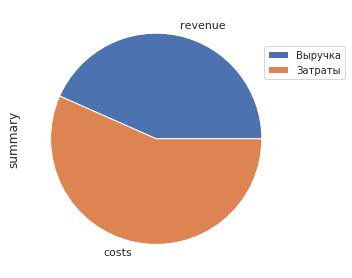

In [101]:
rev_costs.plot(kind='pie', y='summary', grid=True, figsize=(6, 4))
plt.tight_layout(pad=1)
plt.legend(['Выручка', 'Затраты'], bbox_to_anchor=(0.89,0.87), prop={'size':10})

    Видим, что общая сумма затрат на рекламные источники превышает общую выручку.


**Сумма затрат по каждому виду рекламных источников**

In [102]:
source_id_cost = costs.groupby('source_id').agg({'costs': 'sum'}).round(2).sort_values(by='costs', ascending=False)
source_id_cost.head(9)

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


Text(0.5, 1.0, 'Затраты по виду рекламных источников')

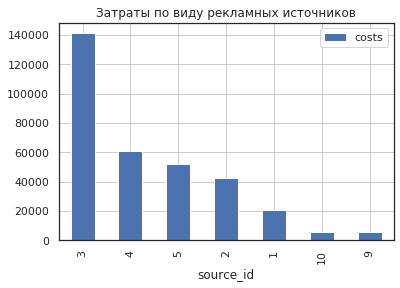

In [134]:
source_id_cost = costs.groupby('source_id').agg({'costs': 'sum'}).round(2).sort_values(by='costs', ascending=False).plot(kind='bar', grid=True, figsize=(6, 4))
plt.title('Затраты по виду рекламных источников')

    * Больше всего потратили на 3ий источник. 
    * Далее по суммам затрат идут 4 и 5 источник.
    * топ-2 самых дешевых источников привлечения: 10, 9


    
**Сумма затрат на рекламные источники по времени (с разбивкой по году и месяцу)**

In [104]:
costs['month'] = costs['date'].dt.month
costs['year']  = costs['date'].dt.year

In [105]:
year_cost = costs.groupby('year').agg({'costs': 'sum'}).round(2).sort_values(by='costs', ascending=False)
year_cost.head(3)

,costs
year,
2017,187961.15
2018,141170.47


Text(0.5, 1.0, 'Затраты на рекламу с разбивкой по годам')

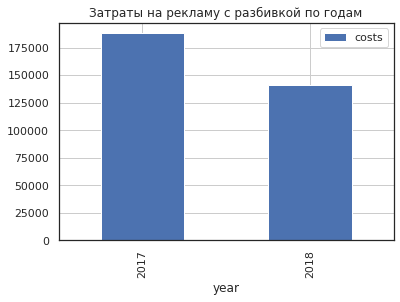

In [135]:
year_cost = costs.groupby('year').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False).plot(kind='bar', grid=True, figsize=(6, 4))
plt.title('Затраты на рекламу с разбивкой по годам')


    За отчетный период в 2017 - 7 месяцев, за отчетный период в 2018 году - 5 месяцев.
    Логично, что в 2017 затрат на рекламные источники - больше. 
    Посмотрим на затраты в среднем по году:

Text(0.5, 1.0, 'Затраты на рекламу в среднем за месяц с разбивкой по годам')

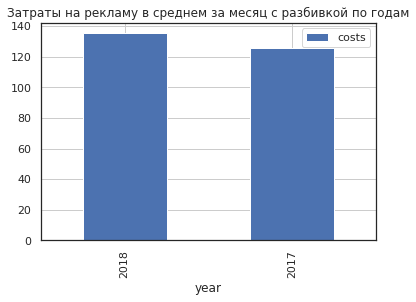

In [136]:
year_cost_mean = costs.groupby('year').agg({'costs': 'mean'}).sort_values(by='costs', ascending=False).plot(kind='bar', grid=True, figsize=(6, 4))
plt.title('Затраты на рекламу в среднем за месяц с разбивкой по годам')

    Разница по затратам на рекламу в 2017 и 2018 сократилась.    
    Посмотрим на затраты по месяцам в каждом году:

In [108]:
month_cost = costs.groupby(['year', 'month']).agg({'costs': 'sum'}).round(2)
month_cost.head(20)

costs
year month          
2017 6      18015.00
     7      18240.59
     8      14790.54
     9      24368.91
     10     36322.88
     11     37907.88
     12     38315.35
2018 1      33518.52
     2      32723.03
     3      30415.27
     4      22289.38
     5      22224.27

Text(0.5, 1.0, 'Затраты на рекламу по месяцам')

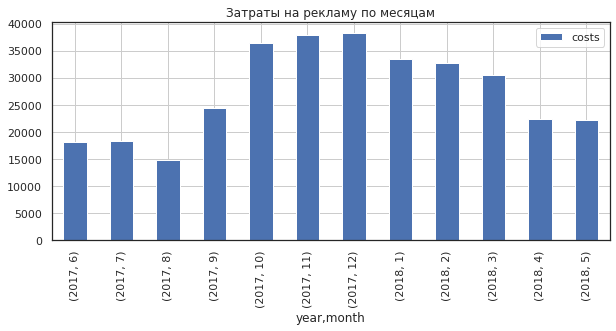

In [140]:
month_cost = costs.groupby(['year', 'month']).agg({'costs': 'sum'}).plot(kind='bar', grid=True, figsize=(10, 4))
plt.title('Затраты на рекламу по месяцам')

   
    * Топ-3 месяцев по затратам на рекламный источник: ноябрь, декабрь, октябрь 2017 г 
    * Топ-3 месяцев по наименьшим затратам на рекламный источник: август, июль, июнь 2017 г
    * в последние 2 месяца 2018 года (апрель, май) идет снижение затрат на рекламу по сравнению с предыдущими месяцами
    

   
**Затраты по рекламным источнкам в динамике**

Text(0.5, 1.0, 'Затраты на рекламу с разбивкой по видам источников и месяцам')

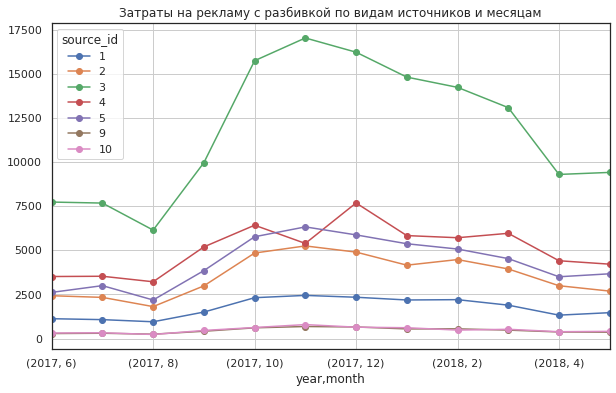

In [141]:
costs.pivot_table(index=['year', 'month'], columns='source_id', values='costs', aggfunc='sum').plot(style='o-', grid=True, figsize=(10, 6))
plt.title('Затраты на рекламу с разбивкой по видам источников и месяцам')

    Первая группа:
    По 10му и 9му (на графике линии совпали) источнику ровная динамика без подъемов и падений, так же мы видим,
    что по этому источнику самый низкий уровень затрат.
    
    1 источник очень схож с 10 и 9 источниками, но по нему уровень затрат чуть выше. Так же небольшие изменения
    в динамике. Есть небольшое падение 08-2017, далее начинается незначительный рост до 03-2018, затем опять падение.
    
    Вторая группа:
    2,5,4 источник. По своей динамике источники очень близки друг к другу, у них совпадают рост и падение.
    Исключение составляет 11-2017, когда по 4ому источнику произошло падение и 12-2017, когда произошел рост. 

    Третья группа:
    3ий источник - самый дорогостоящий. По своей динамике отличен от остальных. После 08-2017 происходит резкое
    увеличение затрат. Максимальная сумма затрат в сентябре 2018. Значительный спад начинается после марта 2018
    
    Общие тенденции:
    У всех рекламных источников произошло сокращение затрат  - 08-2017,12-2017, 04-2018
    У всех рекламных источников произошло увеличение затрат - 09-2017, 10-2017

### Сколько стоило привлечение одного покупателя из каждого источника?<a class="anchor" id="3-3-2-bullet"></a>

In [111]:
marketing['month'] = marketing['date'].dt.month
marketing['year']  = marketing['date'].dt.year

In [112]:
cost_uid_sourse = marketing.groupby('source_id').agg({'uid':'nunique', 'costs': 'mean'}).round(2).sort_values(by='costs', ascending=False)
cost_uid_sourse.head(10)

,uid,costs
source_id,,
3,36522,469.05
4,36522,188.89
5,36522,172.69
2,36522,141.71
1,36522,69.08
10,36522,18.94
9,36522,17.86


Text(0.5, 1.0, 'Стоимость привлечения 1 покупателя в разных источниках')

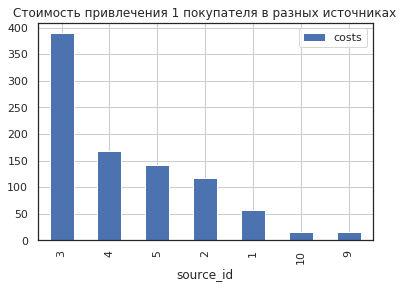

In [142]:
cost_uid_sourse = costs.groupby('source_id').agg({'costs': 'mean'}).round(2).sort_values(by='costs', ascending=False).plot(kind='bar', grid=True, figsize=(6, 4))
plt.title('Стоимость привлечения 1 покупателя в разных источниках')


    * в среднем на покупателя больше всего затрат по 3-ему источнику.
    * На втором и третьем месте источники:4,5. 
    * в среднем на покупателя меньше всего затрат по 10 и 9 источнику

### На сколько окупились расходы на рекламу? (ROMI по упрощённой формуле)<a class="anchor" id="3-3-3-bullet"></a>

In [114]:
# покупатели по каналам
visits_sorted = visits.sort_values(by='session_start_t')

In [115]:
# затраты по каналам
costs_per_source = costs.groupby('source_id').agg({'costs': 'sum'})

In [116]:
# выручка по каналам
first_source_per_user = visits_sorted.groupby('uid').agg({'source_id': 'first'})
client_per_source = orders.merge(first_source_per_user, on='uid')
client_per_source = client_per_source.groupby('source_id').agg({'uid': 'nunique'})

In [144]:
# уникальные пользователи по каналам
uid_per_source = visits_sorted.groupby('source_id').agg({'uid': 'nunique'})
rev_per_source = orders.merge(first_source_per_user, on='uid')
rev_per_source = rev_per_source.groupby('source_id').agg({'revenue': 'sum'})
rev_uid_costs_per_source = pd.concat([costs_per_source, rev_per_source, 
                                      client_per_source],axis=1).fillna(0)
rev_uid_costs_per_source = rev_uid_costs_per_source.reset_index()
rev_uid_costs_per_source.head()

,source_id,costs,revenue,uid
0,1,20833.27,31090.55,2899
1,2,42806.04,46923.61,3506
2,3,141321.63,54511.24,10473
3,4,61073.60,56696.83,10296
4,5,51757.10,52624.02,6931


### LTV по каждому рекламному источнику

In [118]:
rev_uid_costs_per_source['ltv'] = (rev_uid_costs_per_source['revenue'] / rev_uid_costs_per_source['uid']).round(3)
rev_uid_costs_per_source.head(15)

,source_id,costs,revenue,uid,ltv
0,1,20833.27,31090.55,2899,10.725
1,2,42806.04,46923.61,3506,13.384
2,3,141321.63,54511.24,10473,5.205
3,4,61073.60,56696.83,10296,5.507
4,5,51757.10,52624.02,6931,7.593
5,7,0.00,1.22,1,1.220
6,9,5517.49,5759.40,1088,5.294
7,10,5822.49,4450.33,1329,3.349


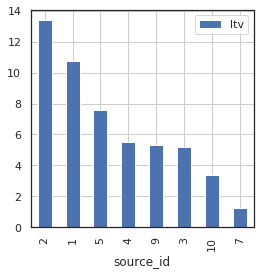

In [119]:
rev_uid_costs_per_source.sort_values(by='ltv', ascending=False).plot(x='source_id', y='ltv', kind='bar', grid=True, figsize=(4, 4))

### CAC по каждому рекламному источнику

In [120]:
rev_uid_costs_per_source['cac'] = (rev_uid_costs_per_source['costs'] / rev_uid_costs_per_source['uid']).round(1)
rev_uid_costs_per_source.head(15)

,source_id,costs,revenue,uid,ltv,cac
0,1,20833.27,31090.55,2899,10.725,7.2
1,2,42806.04,46923.61,3506,13.384,12.2
2,3,141321.63,54511.24,10473,5.205,13.5
3,4,61073.60,56696.83,10296,5.507,5.9
4,5,51757.10,52624.02,6931,7.593,7.5
5,7,0.00,1.22,1,1.220,0.0
6,9,5517.49,5759.40,1088,5.294,5.1
7,10,5822.49,4450.33,1329,3.349,4.4


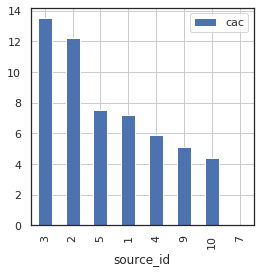

In [121]:
rev_uid_costs_per_source.sort_values(by='cac', ascending=False).plot(x='source_id', y='cac', kind='bar', grid=True, figsize=(4, 4))

### ROMI по каждому рекламному источнику (по упрощенной формуле)

In [122]:
rev_uid_costs_per_source['romi'] = (rev_uid_costs_per_source['revenue'] / rev_uid_costs_per_source['costs']).round(1)
rev_uid_costs_per_source.head(15)

,source_id,costs,revenue,uid,ltv,cac,romi
0,1,20833.27,31090.55,2899,10.725,7.2,1.5
1,2,42806.04,46923.61,3506,13.384,12.2,1.1
2,3,141321.63,54511.24,10473,5.205,13.5,0.4
3,4,61073.60,56696.83,10296,5.507,5.9,0.9
4,5,51757.10,52624.02,6931,7.593,7.5,1.0
5,7,0.00,1.22,1,1.220,0.0,inf
6,9,5517.49,5759.40,1088,5.294,5.1,1.0
7,10,5822.49,4450.33,1329,3.349,4.4,0.8


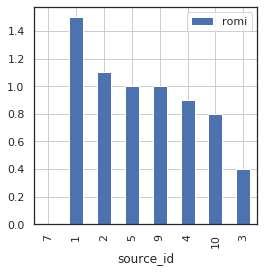

In [123]:
rev_uid_costs_per_source.sort_values(by='romi', ascending=False).plot(x='source_id', y='romi', kind='bar', grid=True, figsize=(4, 4))

    Меньше всего затрат на 9 и 10 рекламный источник. Но они не приносят много выручки, поэтому источники
    не являются оптимальными. ( По показатею ROMI 9 источник на 4ом месте, 10 источник на предпоследнем)
    
    ТОП-3 источников по соотношению выручки и затрат:
    1, 2, 5 канал.

    Самым неэффективным каналом оказался 3 канал. Он самый дорогостоящий и при этом по выручке занимает всего 6-ое место.

###  Анализ посещаемости ресурса по типу устройства<a class="anchor" id="3-3-4-bullet"></a>

In [145]:
visits_by_device = visits.groupby('device').agg({'uid': 'count'})
visits_by_device

,uid
device,
desktop,262567
touch,96833


   
Видим, что в 73,06% случаев сервис посещали с ПК и  в 26,94% случаев сайт посещали с мобильных устройсив.

**Общая выручка Яндекс.Афиши по видам устройств**

In [146]:
sales_device = sales.groupby('device').agg({'revenue': 'sum'}).round(2)
sales_device

,revenue
device,
desktop,6447893.99
touch,514313.36


Text(0.5, 1.0, 'Общая выручка Яндекс.Афиши по видам устройств')

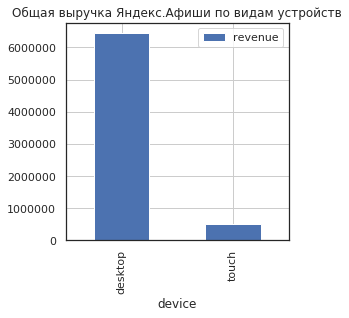

In [147]:
sales_device = sales.groupby('device').agg({'revenue': 'sum'}).plot(kind='bar', grid=True, figsize=(4, 4))
plt.title('Общая выручка Яндекс.Афиши по видам устройств')

**Общая выручка Яндекс.Афиши по видам устройств с разбивкой по годам**

In [128]:
sales.pivot_table(index='year', columns='device', values='revenue', aggfunc='sum').round(1)

device,desktop,touch
year,,
2017,3522678.7,295414.5
2018,2925215.3,218898.8


Text(0.5, 1.0, 'Выручка Яндекс.Афиши по видам устройств и годам')

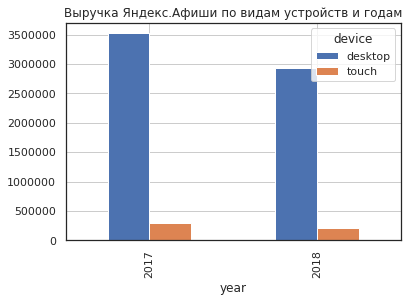

In [148]:
sales.pivot_table(index='year', columns='device', values='revenue', aggfunc='sum').plot(kind='bar', grid=True, figsize=(6, 4))
plt.title('Выручка Яндекс.Афиши по видам устройств и годам')

**Общая выручка Яндекс.Афиши по видам устройств с разбивкой по годам и месяцам**

In [130]:
sales.pivot_table(index=('year', 'month'), columns='device', values='revenue', aggfunc='sum').round(1)

device        desktop     touch
year month                     
2017 6       243927.0    9397.5
     7       214176.8    9754.2
     8       214823.8   13634.4
     9       664880.9   25031.3
     10      515669.9   81307.1
     11      631210.6  102463.8
     12     1037989.7   53826.3
2018 1       572842.8   36077.3
     2       694623.9   32254.5
     3       623383.3   58243.6
     4       511988.1   37637.6
     5       522377.2   54685.9

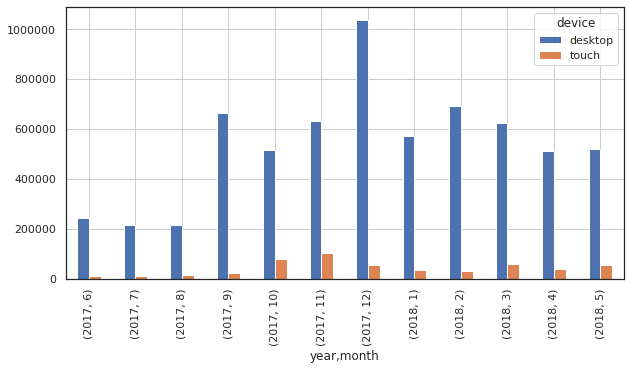

In [151]:
sales.pivot_table(index=('year', 'month'), columns='device', values='revenue', aggfunc='sum').plot(kind='bar', grid=True, figsize=(10, 5))

    Мы видим, что пользователи использующие сервис Яндекс.Афиша в основном используют ПК и редко обращаются к
    данному сервису через мобильные телефоны. Может быть мобильная версия сайта не достаточна удобна для пользователей
    и через нее проблематичней делать заказы. Обратимся к таблице visits, чтобы посмотреть количество сессий на ПК
    и моб.тел, а также продолжительность сессий.

In [133]:
visits.groupby('device').agg({'session_duration_sec':'sum', 'session_start_t':'count'})

,session_duration_sec,session_start_t
device,,
desktop,184833246,262567
touch,46442986,96833


    * Количество сессий на ПК больше в 2,7 раза.
    * Продолжительность сессий на ПК - 51342,6 часов.
    * Продолжительность сессий на моб.телефоне - 12900,8 часов.
    Соответственно продолжительность сессий на ПК больше в 4 раза

## Шаг 4. Вывод<a class="anchor" id="4-bullet"></a>


    
Средняя продолжительность сессии длится - 60 секунд.
В среднем пользователи начинают покупать через минуту после начала сессии. Т.е. пользователи знают точно, что они хотят приобрести. 

***DAU***, количество уникальных пользователей в день: 908
    
***WAU***, количество уникальных пользователей в неделю: 5716
    
***MAU***, количество уникальных пользователей в месяц: 23228
    
***Sticky Factor*** (месячный) - 3.9 %

Нормальным считается показатель Sticky factor (месячный) - порядка 20-18%. В данном случае 3,9%, т.е. пользователи в среднем в течение месяца заходил лишь один раз.

После первого месяца количество посетителей и количество покупателей в когорте сильно снижается.

***Retention по визитам***. В первый месяц мы видим низкий коэфициет удержания:
* до декабря 2017 - от 7,7% до 8,5% (исключение составляет июль 2017 - 5,6%)
* с декабря 2017 - от 6 % до 4,2%

    Это важный сигнал того, что нужно сосредоточиться на удержании покупателей в первый месяц, ведь большая часть активных покупателей отказывается от сервиса именно в этот период.
У первый когорты самый высокий коэфициент удержания даже спустя год жизни - 4,5%
    
При этом во всех когортах ***средний чек*** пользователей возрастает на следующий месяц после месяца первой покупки. В когортах "2018-03" средний чек растёт с течением времени. В остальных когортах средний чек варьируется, то идет рост, потом спад и далее опять рост.
    
С декабря 2017 число покупателей в каждой следующей кагорте падает. Значит, в Яндекс.Афиша со временем приходит всё меньше и меньше новых покупателей.
    
***Первая когорта*** приносит больше всего денег даже после года существования когорты.
У первый когорты спустя год самый высокий коэфициент  удержания Retention Rate. Необходимо подробнее изучить первую когорту и выявить факторы, удерживающие данную ее.
    
***Рекламные источники***
    
Топ-3 месяцев по затратам на рекламный источник: ноябрь, декабрь, октябрь 2017 г

Меньше всего затрат на 9 и 10 рекламный источник. Но они не приносят много выручки, поэтому источники не являются оптимальными. ( По показатею ROMI 9 источник на 4ом месте, 10 источник на предпоследнем)
    
ТОП-3 источников по соотношению выручки и затрат: 1, 2, 5 канал.
    
Самый неэффективным каналом оказался 3 канал. Он самый дорогостоящий и при этом по выручке занимает всего 6-ое место.

    
***Устройства***
    
Пользователи заходят на сервис Яндекс.Афиша в основном через ПК и редко обращаются к данному сервису через мобильные устройства. Может быть мобильная версия сайта не достаточна удобна для пользователей и через нее проблематичней делать заказы.
    
•	Количество сессий на ПК больше в 2,7 раза, чем на моб.устройстве.
•	Продолжительность сессий на ПК больше в 4 разаб чем на моб.устройстве.


